# **좌표 맵을 이미지 채널에 추가하여 훈련을 진행한 모델 성능 비교 결과**

# **데이터 로드 및 증강**

In [1]:
# 드라이브 마운트
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
# 모델 분석 및 시각화 도구
import os
import math
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
import xml.etree.ElementTree as ET
from PIL import Image
from collections import Counter
from tqdm import tqdm
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Scikit-learn (데이터 전처리 및 모델 평가)
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
from sklearn.preprocessing import LabelEncoder, LabelBinarizer

# 모델 설계
import tensorflow as tf

# 모델 구조 및 레이어
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import (Input, Dense, Conv2D, MaxPooling2D,
Flatten, Dropout, BatchNormalization,
LeakyReLU, GlobalAveragePooling2D, concatenate)

# 사전 훈련된 모델
from tensorflow.keras.applications import EfficientNetB0, ResNet50, MobileNetV2, MobileNetV3Small, VGG16, InceptionV3, Xception, DenseNet121

# 컴파일 및 훈련 관련
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.utils import to_categorical

In [3]:
# 3채널 RGB 이미지에 좌표 맵을 추가하여 5채널 이미지로 변환하는 함수
def add_coord_channels(image):
  image_size = image.shape[0]
  axis_vec = np.linspace(-1, 1, image_size, dtype=np.float32)
  x_coords, y_coords = np.meshgrid(axis_vec, axis_vec)
  x_coords = np.expand_dims(x_coords, axis=-1)
  y_coords = np.expand_dims(y_coords, axis=-1)
  return np.concatenate([image, x_coords, y_coords], axis=-1)

# 5채널 이미지 데이터셋, 위치 정보 데이터셋를 로드하는 함수
def load_original_data(csv_path, image_root, image_size):
  df = pd.read_csv(csv_path)
  images, coords, labels = [], [], []

  for _, row in tqdm(df.iterrows(), total=df.shape[0]):
    img_path = os.path.join(image_root, row['class'], row['cropped_image'])
    img = cv2.imread(img_path)

    if img is None:
      print(f"경고: 이미지를 로드할 수 없습니다 - {img_path}")
      continue

    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = cv2.resize(img, image_size)

    # RGB 채널만 0~1 사이로 정규화
    img_normalized = img.astype('float32') / 255.0

    # 정규화된 RGB 이미지에 좌표 채널 추가
    img_5_channels = add_coord_channels(img_normalized)

    coord_data = [row['x_center_norm'], row['y_center_norm'], row['width_norm'], row['height_norm'],row['radius'], row['theta']]
    images.append(img_5_channels)
    coords.append(coord_data)
    labels.append(row['class'])

  print(f"-> 원본 데이터 로딩 완료: {len(images)}개 샘플")
  return np.array(images), np.array(coords, dtype=np.float32), np.array(labels)

# 클래스 별 데이터의 개수를 맞추는 데이터 증강 함수
def balance_data_with_augmentation(original_images, original_coords, original_labels):

  # 데이터 증강 객체 정의
  datagen = ImageDataGenerator(
  rotation_range=20, width_shift_range=0.1, height_shift_range=0.1,
  zoom_range=0.1, horizontal_flip=True, vertical_flip=True, fill_mode='nearest'
  )

  # 클래스별 데이터 수 확인 및 목표 개수 설정
  class_counts = pd.Series(original_labels).value_counts()
  target_count = class_counts.max()
  print(f"-> 데이터 증강 목표 개수 (각 클래스별): {target_count}")

  # 증강된 데이터만을 담을 리스트 초기화
  augmented_images, augmented_coords, augmented_labels = [], [], []

  # 소수 클래스에 대해서만 데이터 증강 수행
  for class_name, current_count in class_counts.items():
    if current_count < target_count:
      num_to_augment = target_count - current_count
      print(f"-> '{class_name}' 클래스 증강: +{num_to_augment}개")
      class_indices = np.where(original_labels == class_name)[0]
      images_to_augment = original_images[class_indices]
      coords_to_augment = original_coords[class_indices]

      for _ in range(num_to_augment):
        idx_to_pick = np.random.randint(0, len(images_to_augment))
        image_5_channels = images_to_augment[idx_to_pick]
        coord = coords_to_augment[idx_to_pick]
        image_rgb = image_5_channels[:,:,:3]
        coord_map = image_5_channels[:,:,3:]
        image_rgb_reshaped = image_rgb.reshape((1, *image_rgb.shape))
        augmented_rgb_batch = next(datagen.flow(image_rgb_reshaped, batch_size=1))
        augmented_rgb = np.squeeze(augmented_rgb_batch, axis=0)
        augmented_5_channels_image = np.concatenate([augmented_rgb, coord_map], axis=-1)
        augmented_images.append(augmented_5_channels_image)
        augmented_coords.append(coord)
        augmented_labels.append(class_name)

  # 원본 데이터와 증강된 데이터를 결합
  balanced_images = np.concatenate([original_images, np.array(augmented_images)], axis=0)
  balanced_coords = np.concatenate([original_coords, np.array(augmented_coords)], axis=0)
  balanced_labels = np.concatenate([original_labels, np.array(augmented_labels)], axis=0)

  # 최종 데이터 섞기
  return shuffle(balanced_images, balanced_coords, balanced_labels, random_state=42)


In [4]:
dataset_path = "/content/drive/MyDrive/ACK2025_Wafer/YOLO/Defect_Pattern_CNN_Dataset"
zip_file_name = "Pattern_Cropped_Coordinated_Dataset_v3.zip"
unzipped_dataset_path = "Pattern_Cropped_Coordinated_Dataset_v3"

# Colab 로컬로 데이터셋 이동 및 복사
print("데이터셋을 Colab 로컬 환경으로 복사합니다...")

# 변수를 사용하여 파일 경로를 동적으로 생성
zip_file_path_in_drive = os.path.join(dataset_path, zip_file_name)
!cp "{zip_file_path_in_drive}" /content/
print("압축 해제를 시작합니다...")
!unzip -o -q /content/"{zip_file_name}" -d /content/
print("데이터셋 준비 완료.")

# 로컬 폴더 목록 확인
print("\n/content/ 폴더 내용 확인:")
!ls -l /content/

데이터셋을 Colab 로컬 환경으로 복사합니다...
압축 해제를 시작합니다...
데이터셋 준비 완료.

/content/ 폴더 내용 확인:
total 156472
drwx------  6 root root      4096 Aug  7 04:38 drive
drwxrwxrwx 10 root root      4096 Aug  3 07:41 Pattern_Cropped_Coordinated_Dataset_v3
-rw-------  1 root root 160211512 Aug  7 04:38 Pattern_Cropped_Coordinated_Dataset_v3.zip
drwxr-xr-x  1 root root      4096 Aug  5 17:22 sample_data


In [5]:
# 데이터셋 경로 설정 및 이미지 크기 조절
csv_path = os.path.join(dataset_path, "bbox_info_v2.csv")
image_path = os.path.join("/content/", unzipped_dataset_path)
image_size = (128, 128)


# 원본 데이터 로드 ( X: 입력 데이터, y: 라벨 데이터 )
X_original_images, X_original_coords, y_original_labels = load_original_data(csv_path, image_path, image_size)

# 데이터 증강
X_images, X_coords, y_labels_str = balance_data_with_augmentation(X_original_images, X_original_coords, y_original_labels)

# 좌표 데이터의 타입 변환
X_coords = X_coords.astype('float32')

# 원 핫 인코딩
encoder = LabelEncoder()
y_labels_encoded = encoder.fit_transform(y_labels_str)
classes_num = len(encoder.classes_)
y_labels_categorical = to_categorical(y_labels_encoded, num_classes=classes_num)

# 데이터셋 정보 출력
print(f"\n총 샘플 개수: {len(X_images)}")
print(f"이미지 데이터 형태: {X_images.shape}")
print(f"좌표 데이터 형태: {X_coords.shape}")
print(f"라벨 데이터 형태: {y_labels_categorical.shape}")
print(f"클래스 종류 ({classes_num}개): {encoder.classes_}")
print("\n최종 클래스별 데이터 분포:")
print(pd.Series(y_labels_str).value_counts())

 25%|██▌       | 1659/6570 [00:02<00:10, 489.36it/s]

경고: 이미지를 로드할 수 없습니다 - /content/Pattern_Cropped_Coordinated_Dataset_v3/Edge-Loc/Donut99_obj0.png


100%|██████████| 6570/6570 [00:18<00:00, 360.31it/s]


-> 원본 데이터 로딩 완료: 6569개 샘플
-> 데이터 증강 목표 개수 (각 클래스별): 1000
-> 'Edge-Loc' 클래스 증강: +1개
-> 'Random' 클래스 증강: +134개
-> 'Donut' 클래스 증강: +445개
-> 'Near-full' 클래스 증강: +851개

총 샘플 개수: 8000
이미지 데이터 형태: (8000, 128, 128, 5)
좌표 데이터 형태: (8000, 6)
라벨 데이터 형태: (8000, 8)
클래스 종류 (8개): ['Center' 'Donut' 'Edge-Loc' 'Edge-Ring' 'Loc' 'Near-full' 'Random'
 'Scratch']

최종 클래스별 데이터 분포:
Edge-Loc     1000
Edge-Ring    1000
Loc          1000
Donut        1000
Near-full    1000
Random       1000
Scratch      1000
Center       1000
Name: count, dtype: int64


In [6]:
# 학습용, 테스트용 데이터 분리
X_img_train, X_img_test, X_coords_train, X_coords_test, y_train, y_test = train_test_split(
  X_images,
  X_coords,
  y_labels_categorical,
  test_size=0.2,  # 20%를 테스트 데이터로 사용
  random_state=42,  # 재현성을 위해 랜덤 시드 고정
  stratify=y_labels_categorical
)

# 학습 및 훈련 데이터셋의 데이터 개수 확인
print("\n 학습 데이터셋의 클래스 분포")
y_train_labels = np.argmax(y_train, axis=1) # 원-핫 인코딩 -> 정수 라벨로 변환
print(pd.Series(y_train_labels).map(lambda x: encoder.classes_[x]).value_counts())
print("\n 테스트 데이터셋의 클래스 분포")
y_test_labels = np.argmax(y_test, axis=1) # 원-핫 인코딩 -> 정수 라벨로 변환
print(pd.Series(y_test_labels).map(lambda x: encoder.classes_[x]).value_counts())


 학습 데이터셋의 클래스 분포
Edge-Loc     800
Random       800
Scratch      800
Center       800
Donut        800
Loc          800
Near-full    800
Edge-Ring    800
Name: count, dtype: int64

 테스트 데이터셋의 클래스 분포
Center       200
Edge-Loc     200
Near-full    200
Scratch      200
Loc          200
Donut        200
Edge-Ring    200
Random       200
Name: count, dtype: int64



--- 학습 데이터셋 이미지 샘플 ---


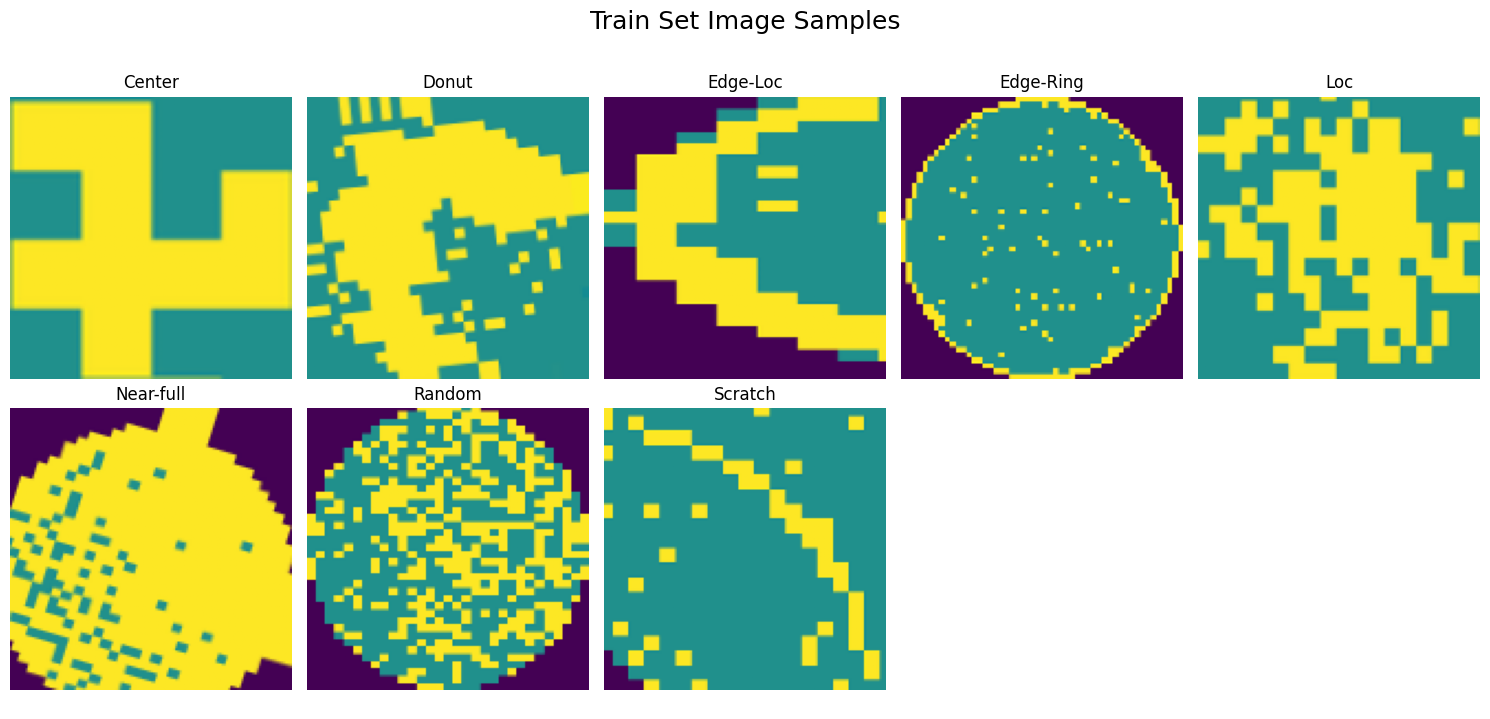

In [7]:
print("\n--- 학습 데이터셋 이미지 샘플 ---")
unique_classes = encoder.classes_
num_classes = len(unique_classes)

# 출력될 이미지 크기 설정
cols = 5
rows = math.ceil(num_classes / cols)
fig, axes = plt.subplots(rows, cols, figsize=(cols * 3, rows * 3.5))
axes = axes.flatten()

# 각 클래스 별 이미지 샘플 출력
for i, class_name in enumerate(unique_classes):
  class_code = encoder.transform([class_name])[0]

  # 각 클래스의 첫 이미지 선
  idx_in_train_set = np.where(y_train_labels == class_code)[0][0]

  # 훈련 데이터에서 이미지 로드
  sample_image = X_img_train[idx_in_train_set]

  # RGB 3개의 채널만을 사용하여 이미지 출력
  sample_image_to_show = sample_image[:, :, :3]

  # 격자를 통해 이미지 출력
  ax = axes[i]
  ax.imshow(sample_image_to_show) # 수정된 변수 사용
  ax.set_title(class_name, fontsize=12)
  ax.axis('off')

# 격자의 빈 공간 제거
for j in range(i + 1, len(axes)):
  axes[j].axis('off')

plt.suptitle('Train Set Image Samples', fontsize=18, y=1.02)
plt.tight_layout()
plt.show()

# **모델 학습**

In [8]:
# 모델 학습 결과 시각화 함수
def plot_training_history(history, model_name):

  # 정확도 그래프
  plt.figure(figsize=(14, 5))
  plt.subplot(1, 2, 1)
  plt.plot(history.history['accuracy'], label='Training Accuracy')
  plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
  plt.title(f'{model_name} - Accuracy', fontsize=14)
  plt.xlabel('Epoch', fontsize=12)
  plt.ylabel('Accuracy', fontsize=12)
  plt.legend()
  plt.grid(True)

  # 손실 그래프
  plt.subplot(1, 2, 2)
  plt.plot(history.history['loss'], label='Training Loss')
  plt.plot(history.history['val_loss'], label='Validation Loss')
  plt.title(f'{model_name} - Loss', fontsize=14)
  plt.xlabel('Epoch', fontsize=12)
  plt.ylabel('Loss', fontsize=12)
  plt.legend()
  plt.grid(True)
  plt.tight_layout()
  plt.show()

# 혼동 행렬 시각화 함수
def plot_confusion_matrix(y_true, y_pred_probs, class_names, normalize=False, title='Confusion Matrix'):

  # 확률을 최종 클래스 예측(인덱스)으로 변환
  y_pred_classes = np.argmax(y_pred_probs, axis=1)
  y_true_classes = np.argmax(y_true, axis=1)

  # normalize 옵션 설정
  if normalize:
    # 'true': 실제 라벨(행)을 기준으로 정규화
    cm = confusion_matrix(y_true_classes, y_pred_classes, normalize='true')
    fmt = '.2f' # 소수점 둘째 자리까지 표시
  else:
    cm = confusion_matrix(y_true_classes, y_pred_classes)
    fmt = 'd' # 정수로 표시

  # 혼동 행렬 시각화
  plt.figure(figsize=(9, 8))
  sns.heatmap(
    cm,
    annot=True,
    fmt=fmt, # [개선 2] 포맷 변경
    cmap='Blues',
    xticklabels=class_names,
    yticklabels=class_names
  )

  plt.xlabel('Predicted Class', fontsize=12)
  plt.ylabel('Actual Class', fontsize=12)
  plt.title(title, fontsize=15)
  plt.show()


## **1. Multi-Input NN with Coordination Map**

In [9]:
# --- 모델 구성 ---

# 입력층
image_input = Input(shape=(128, 128, 5), name='image_input_5channels')
coords_input = Input(shape=(6,), name='coords_input_6features')

# 이미지 처리 브랜치 (NN)
image_flatten = Flatten()(image_input)
image_features = Dense(128, activation='relu')(image_flatten)


# 좌표 처리 브랜치 (MLP)
coords_features = Dense(16, activation='relu')(coords_input)

# 브랜치 결합
combined = concatenate([image_features, coords_features])

# 최종 분류층
x1 = Dense(64, activation='relu')(combined)

# 출력층
output = Dense(num_classes, activation='softmax')(x1)


# 최종 모델 생성
model_coordmap_nn = Model(inputs=[image_input, coords_input], outputs=output)

# 모델 구조 확인
model_coordmap_nn.summary()

# --- 모델 컴파일 ---
optimizer = Adam(learning_rate=0.0001)
model_coordmap_nn.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

# --- 모델 훈련 ---

# 조기 종료(Early Stopping) 콜백 설정
early_stopping = EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True)

# 모델 훈련 실행
history_coordmap_nn = model_coordmap_nn.fit(
  [X_img_train, X_coords_train],
  y_train,
  epochs=100,
  batch_size=32,
  validation_data=([X_img_test, X_coords_test], y_test),
  callbacks=[early_stopping]
)

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ image_input_5chann… │ (None, 128, 128,  │          0 │ -                 │
│ (InputLayer)        │ 5)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten (Flatten)   │ (None, 81920)     │          0 │ image_input_5cha… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ coords_input_6feat… │ (None, 6)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 128)       │ 10,485,888 │ flatten[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 16)        │        112 │ coords_input_6fe… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 144)       │          0 │ dense[0][0],      │
│ (Concatenate)       │                   │            │ dense_1[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_2 (Dense)     │ (None, 64)        │      9,280 │ concatenate[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_3 (Dense)     │ (None, 8)         │        520 │ dense_2[0][0]     │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 10,495,800 (40.04 MB)

 Trainable params: 10,495,800 (40.04 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100
200/200 ━━━━━━━━━━━━━━━━━━━━ 6s 15ms/step - accuracy: 0.5030 - loss: 1.4510 - val_accuracy: 0.7138 - val_loss: 0.7482
Epoch 2/100
200/200 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - accuracy: 0.7712 - loss: 0.6325 - val_accuracy: 0.7806 - val_loss: 0.5859
Epoch 3/100
200/200 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - accuracy: 0.7906 - loss: 0.5586 - val_accuracy: 0.8131 - val_loss: 0.4964
Epoch 4/100
200/200 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - accuracy: 0.8088 - loss: 0.4990 - val_accuracy: 0.8062 - val_loss: 0.5378
Epoch 5/100
200/200 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - accuracy: 0.8352 - loss: 0.4701 - val_accuracy: 0.7275 - val_loss: 0.6847
Epoch 6/100
200/200 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - accuracy: 0.8397 - loss: 0.4294 - val_accuracy: 0.8150 - val_loss: 0.5100
Epoch 7/100
200/200 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - accuracy: 0.8252 - loss: 0.4450 - val_accuracy: 0.7094 - val_loss: 0.8817
Epoch 8/100
200/200 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - accuracy: 0.8527 - loss: 0.3999 - val_acc

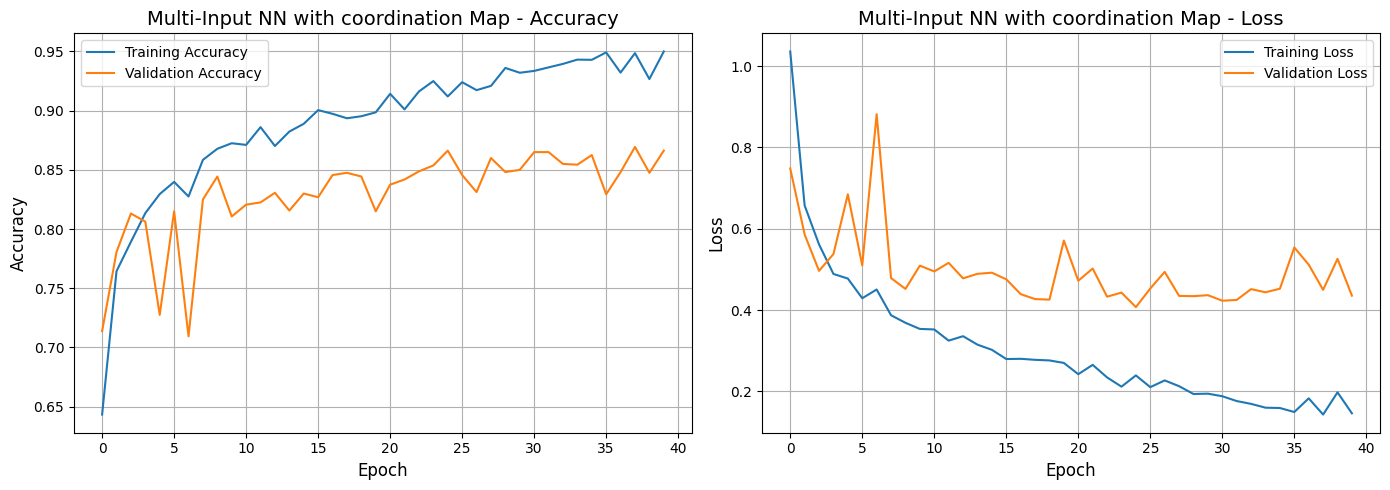

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step


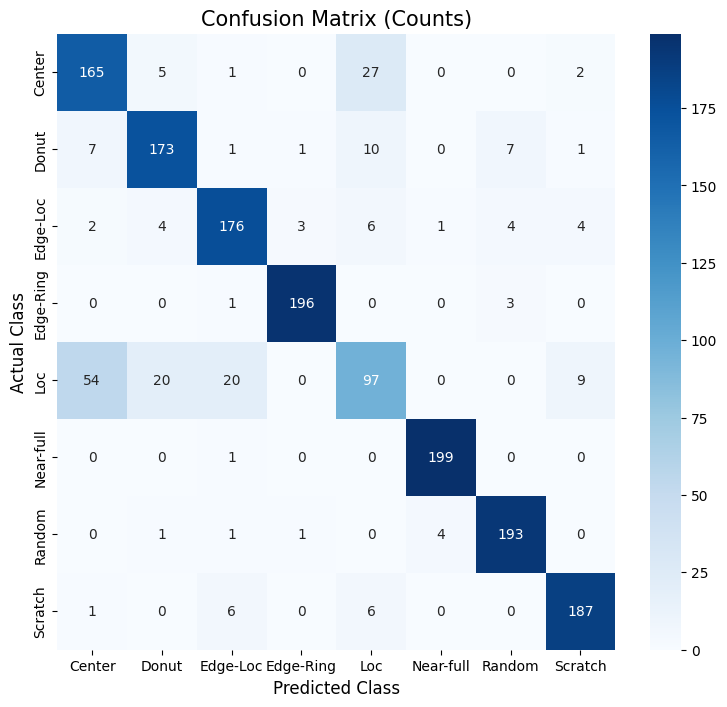

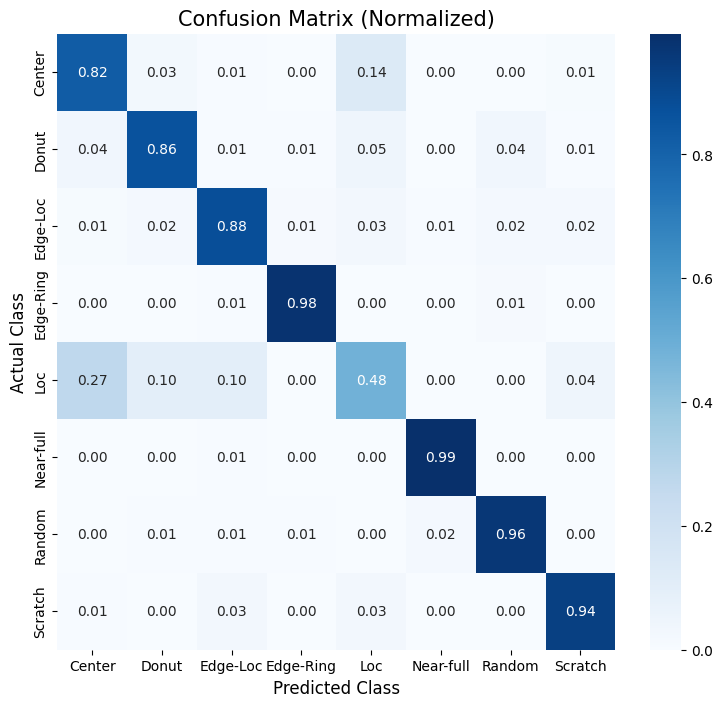

In [10]:
# 훈련 모델 성능 시각화
plot_training_history(history_coordmap_nn, "Multi-Input NN with coordination Map")

# 테스트 데이터로 예측 수행
y_pred_probs = model_coordmap_nn.predict([X_img_test, X_coords_test])

# 혼동 행렬 시각화
plot_confusion_matrix(y_test, y_pred_probs, encoder.classes_, normalize=False, title='Confusion Matrix (Counts)')

plot_confusion_matrix(y_test, y_pred_probs, encoder.classes_, normalize=True, title='Confusion Matrix (Normalized)')

## **2. Multi-Input DNN with Coordination Map**

In [11]:
# --- 모델 구성 ---

# 입력층 설정
image_input = Input(shape=(128, 128, 5), name='image_input_5channels')
coords_input = Input(shape=(6,), name='coords_input_6features')

# 이미지 처리 브랜치
image_flatten = Flatten()(image_input)
image_features = Dense(128, activation='relu')(image_flatten)
image_features = Dense(64, activation='relu')(image_features)

# 좌표 처리 브랜치
coords_features = Dense(16, activation='relu')(coords_input)
coords_features = Dense(8, activation='relu')(coords_features)

# 브랜치 결합
combined = concatenate([image_features, coords_features])

# 최종 분류층
x2 = Dense(64, activation='relu')(combined)
output = Dense(classes_num, activation='softmax')(x2)

# 최종 모델 생성
model_coordmap_dnn = Model(inputs=[image_input, coords_input], outputs=output)

# 모델 구조 확인
model_coordmap_dnn.summary()

# --- 모델 컴파일 ---
model_coordmap_dnn.compile(
optimizer='adam',
loss='categorical_crossentropy',
metrics=['accuracy']
)
# --- 모델 학습 ---

# 조기 종료 콜백 설정
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# 모델 훈련 실행
history_coordmap_dnn = model_coordmap_dnn.fit(
  [X_img_train, X_coords_train], y_train,
  epochs=50,
  batch_size=32,
  validation_data=([X_img_test, X_coords_test], y_test),
  callbacks=[early_stopping]
)

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ image_input_5chann… │ (None, 128, 128,  │          0 │ -                 │
│ (InputLayer)        │ 5)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_1 (Flatten) │ (None, 81920)     │          0 │ image_input_5cha… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ coords_input_6feat… │ (None, 6)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_4 (Dense)     │ (None, 128)       │ 10,485,888 │ flatten_1[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_6 (Dense)     │ (None, 16)        │        112 │ coords_input_6fe… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_5 (Dense)     │ (None, 64)        │      8,256 │ dense_4[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_7 (Dense)     │ (None, 8)         │        136 │ dense_6[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_1       │ (None, 72)        │          0 │ dense_5[0][0],    │
│ (Concatenate)       │                   │            │ dense_7[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_8 (Dense)     │ (None, 64)        │      4,672 │ concatenate_1[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_9 (Dense)     │ (None, 8)         │        520 │ dense_8[0][0]     │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 10,499,584 (40.05 MB)

 Trainable params: 10,499,584 (40.05 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
200/200 ━━━━━━━━━━━━━━━━━━━━ 6s 16ms/step - accuracy: 0.4768 - loss: 4.8216 - val_accuracy: 0.7119 - val_loss: 0.8248
Epoch 2/50
200/200 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - accuracy: 0.7598 - loss: 0.6823 - val_accuracy: 0.7556 - val_loss: 0.6062
Epoch 3/50
200/200 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - accuracy: 0.8175 - loss: 0.5120 - val_accuracy: 0.8475 - val_loss: 0.4648
Epoch 4/50
200/200 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - accuracy: 0.8719 - loss: 0.4069 - val_accuracy: 0.8125 - val_loss: 0.5674
Epoch 5/50
200/200 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - accuracy: 0.8710 - loss: 0.3785 - val_accuracy: 0.8081 - val_loss: 0.5837
Epoch 6/50
200/200 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - accuracy: 0.8729 - loss: 0.3927 - val_accuracy: 0.8744 - val_loss: 0.3968
Epoch 7/50
200/200 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - accuracy: 0.8949 - loss: 0.3221 - val_accuracy: 0.8781 - val_loss: 0.4549
Epoch 8/50
200/200 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - accuracy: 0.8802 - loss: 0.3650 - val_accuracy: 0

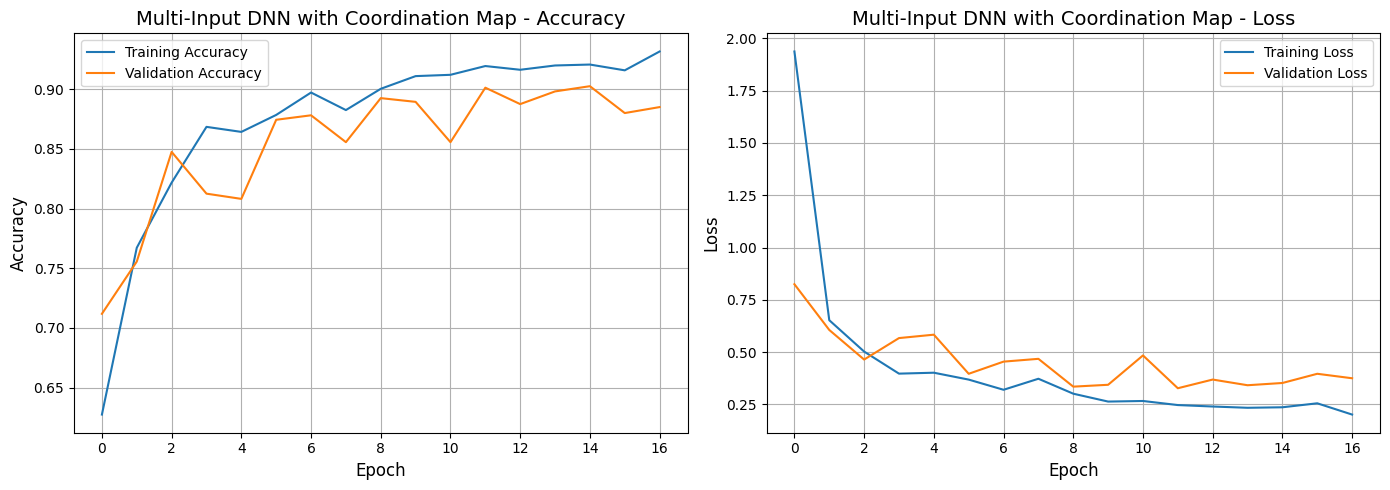

50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step


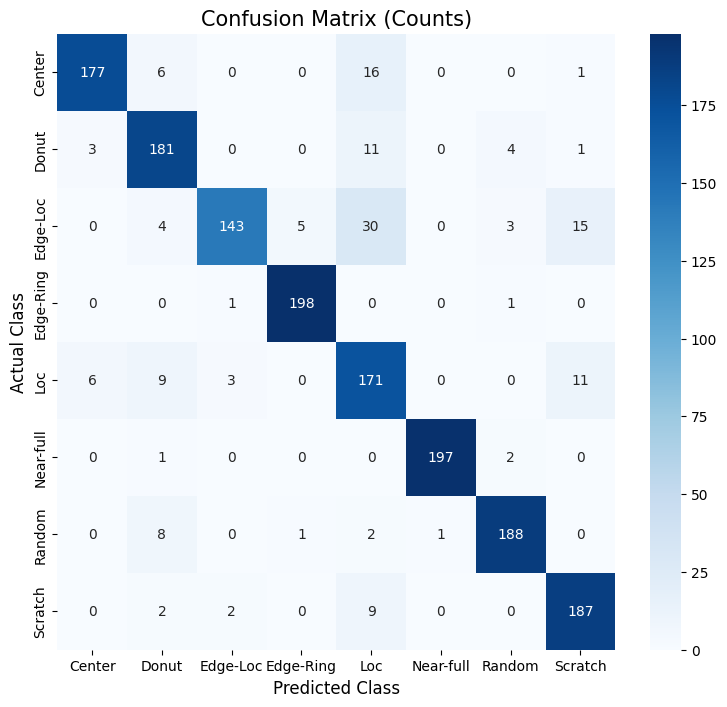

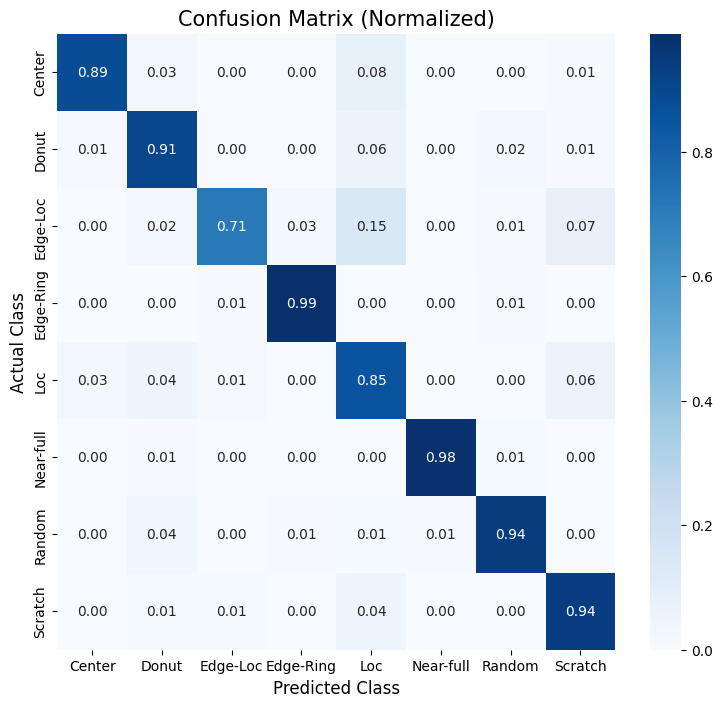

In [12]:
# 훈련 모델 성능 시각화
plot_training_history(history_coordmap_dnn, "Multi-Input DNN with Coordination Map")

# 테스트 데이터로 예측 수행
y_pred_probs = model_coordmap_dnn.predict([X_img_test, X_coords_test])

# 혼동 행렬 시각화
plot_confusion_matrix(y_test, y_pred_probs, encoder.classes_, normalize=False, title='Confusion Matrix (Counts)')

plot_confusion_matrix(y_test, y_pred_probs, encoder.classes_, normalize=True, title='Confusion Matrix (Normalized)')

## **3. Multi-Input CNN with Coordination Map**

In [13]:
# --- 모델 구성 ---

# 입력층
image_input = Input(shape=(128, 128, 5), name='image_input_5channels')
coords_input = Input(shape=(6,), name='coords_input_6features')


# 이미지 처리 브랜치 (CNN)
x3 = Conv2D(32, (3, 3), activation='relu')(image_input)
x3 = BatchNormalization()(x3)
x3 = MaxPooling2D(pool_size=(2, 2))(x3)
x3 = Dropout(0.3)(x3)

x3 = Conv2D(64, (3, 3), activation='relu')(x3)
x3 = BatchNormalization()(x3)
x3 = MaxPooling2D(pool_size=(2, 2))(x3)
x3 = Dropout(0.3)(x3)

x3 = Conv2D(128, (3, 3), activation='relu')(x3)
x3 = BatchNormalization()(x3)
x3 = MaxPooling2D(pool_size=(2, 2))(x3)
x3 = Dropout(0.5)(x3)

image_features = Flatten()(x3)

# 좌표 처리 브랜치 (MLP)
coords_features = Dense(16, activation='relu')(coords_input)

# 브랜치 결합
combined = concatenate([image_features, coords_features])

# 출력층
z3 = Dense(128, activation='relu')(combined)
z3 = BatchNormalization()(z3)
z3 = Dropout(0.5)(z3)
output = Dense(classes_num, activation='softmax')(z3)

# 최종 모델 생성
model_coordmap_cnn = Model(inputs=[image_input, coords_input], outputs=output)

# 모델 구조 확인
model_coordmap_cnn.summary()

# --- 모델 컴파일 ---
optimizer = Adam(learning_rate=0.0001)
model_coordmap_cnn.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

# --- 모델 학습 ---
early_stopping = EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True)
history_coordmap_cnn = model_coordmap_cnn.fit(
  [X_img_train, X_coords_train],
  y_train,
  epochs=100,
  batch_size=32,
  validation_data=([X_img_test, X_coords_test], y_test),
  callbacks=[early_stopping]
)

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ image_input_5chann… │ (None, 128, 128,  │          0 │ -                 │
│ (InputLayer)        │ 5)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 126, 126,  │      1,472 │ image_input_5cha… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 126, 126,  │        128 │ conv2d[0][0]      │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 63, 63,    │          0 │ batch_normalizat… │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 63, 63,    │          0 │ max_pooling2d[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 61, 61,    │     18,496 │ dropout[0][0]     │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 61, 61,    │        256 │ conv2d_1[0][0]    │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_1     │ (None, 30, 30,    │          0 │ batch_normalizat… │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (None, 30, 30,    │          0 │ max_pooling2d_1[… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 28, 28,    │     73,856 │ dropout_1[0][0]   │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 28, 28,    │        512 │ conv2d_2[0][0]    │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_2     │ (None, 14, 14,    │          0 │ batch_normalizat… │
│ (MaxPooling2D)      │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_2 (Dropout) │ (None, 14, 14,    │          0 │ max_pooling2d_2[… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ coords_input_6feat… │ (None, 6)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_2 (Flatten) │ (None, 25088)     │          0 │ dropout_2[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_10 (Dense)    │ (None, 16)        │        112 │ coords_input_6fe… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_2       │ (None, 25104)     │          0 │ flatten_2[0][0],  │
│ (Concatenate)       │                   │            │ dense_10[0][0]    │
├─────────────────────┼───────────────────┼────────────┼─────────────────

 Total params: 3,309,816 (12.63 MB)

 Trainable params: 3,309,112 (12.62 MB)

 Non-trainable params: 704 (2.75 KB)

Epoch 1/100
200/200 ━━━━━━━━━━━━━━━━━━━━ 17s 35ms/step - accuracy: 0.5147 - loss: 1.5404 - val_accuracy: 0.1250 - val_loss: 5.5227
Epoch 2/100
200/200 ━━━━━━━━━━━━━━━━━━━━ 5s 25ms/step - accuracy: 0.7413 - loss: 0.7225 - val_accuracy: 0.2050 - val_loss: 4.4705
Epoch 3/100
200/200 ━━━━━━━━━━━━━━━━━━━━ 5s 25ms/step - accuracy: 0.7835 - loss: 0.6246 - val_accuracy: 0.4094 - val_loss: 3.2693
Epoch 4/100
200/200 ━━━━━━━━━━━━━━━━━━━━ 5s 25ms/step - accuracy: 0.7863 - loss: 0.5975 - val_accuracy: 0.5337 - val_loss: 3.5171
Epoch 5/100
200/200 ━━━━━━━━━━━━━━━━━━━━ 5s 25ms/step - accuracy: 0.8140 - loss: 0.5285 - val_accuracy: 0.5975 - val_loss: 2.4155
Epoch 6/100
200/200 ━━━━━━━━━━━━━━━━━━━━ 5s 25ms/step - accuracy: 0.8275 - loss: 0.5179 - val_accuracy: 0.6106 - val_loss: 3.4138
Epoch 7/100
200/200 ━━━━━━━━━━━━━━━━━━━━ 5s 25ms/step - accuracy: 0.8303 - loss: 0.4666 - val_accuracy: 0.6037 - val_loss: 3.6455
Epoch 8/100
200/200 ━━━━━━━━━━━━━━━━━━━━ 5s 25ms/step - accuracy: 0.8336 - loss: 0.4608 -

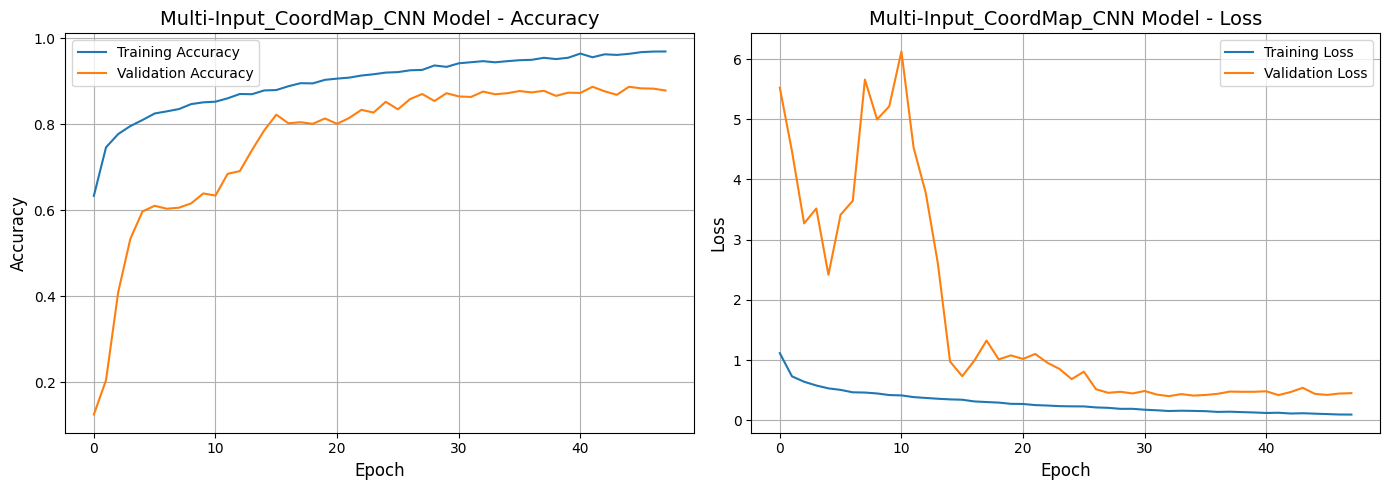

50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step


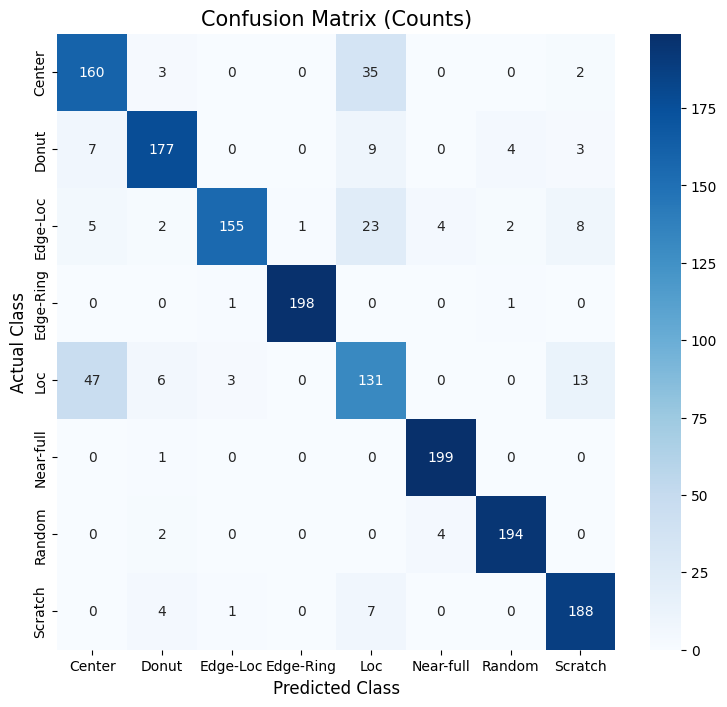

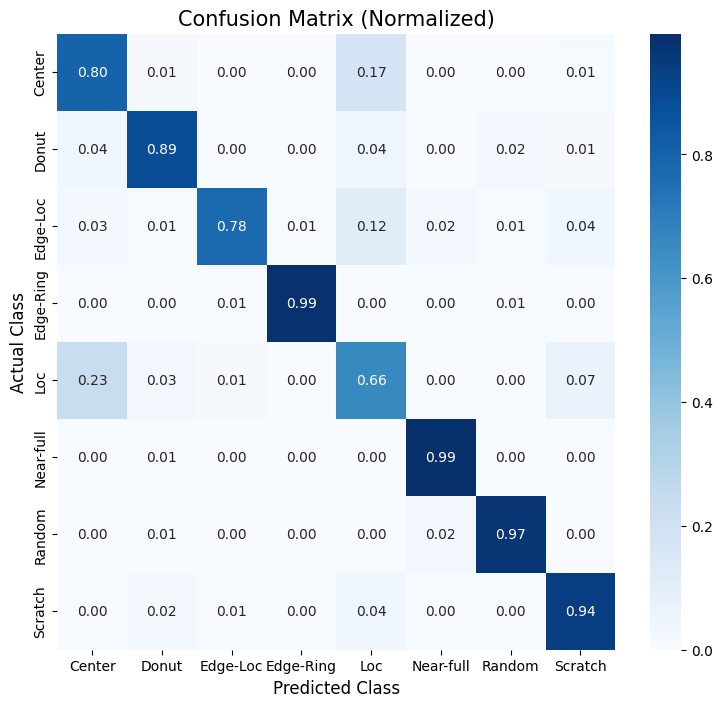

In [14]:
# 훈련 모델 성능 시각화
plot_training_history(history_coordmap_cnn, "Multi-Input_CoordMap_CNN Model")

# 테스트 데이터로 예측 수행
y_pred_probs = model_coordmap_cnn.predict([X_img_test, X_coords_test])

# 혼동 행렬 시각화
plot_confusion_matrix(y_test, y_pred_probs, encoder.classes_, normalize=False, title='Confusion Matrix (Counts)')

plot_confusion_matrix(y_test, y_pred_probs, encoder.classes_, normalize=True, title='Confusion Matrix (Normalized)')

## **4. Multi-Input ANN with Coordination Map**

In [15]:
# --- 모델 구성 ---

# 입력층 정의
image_input = Input(shape=(128, 128, 5), name='image_input_5channels')
coords_input = Input(shape=(6,), name='coords_input_6features')


# 이미지 처리 브랜치
x4 = Flatten()(image_input)
x4 = Dense(256)(x4)
x4 = LeakyReLU(alpha=0.2)(x4) # LeakyReLU 활성화 함수 사용
x4 = Dropout(0.5)(x4)         # 과적합 방지를 위한 Dropout (50% 뉴런 비활성화)

x4 = Dense(128)(x4)
x4 = LeakyReLU(alpha=0.2)(x4)
x4 = Dropout(0.5)(x4)
image_features = x4 # 이미지 브랜치의 최종 특징


# 좌표 처리 브랜치
coords_features = Dense(16, activation='relu')(coords_input)


# 브랜치 결합
combined = concatenate([image_features, coords_features])


# 최종 분류층
z4 = Dense(64, activation='relu')(combined)
output = Dense(classes_num, activation='softmax')(z4) # NUM_CLASSES는 이전에 정의된 클래스 개수


# 최종 모델 생성
model_coordmap_ann = Model(inputs=[image_input, coords_input], outputs=output)

# 모델 구조 확인
model_coordmap_ann.summary()


# --- 모델 컴파일 ---
model_coordmap_ann.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])


# --- 모델 학습 ---

# 조기 종료 콜백 설정
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True) # patience 증가

# 모델 훈련 실행
history_coordmap_ann = model_coordmap_ann.fit(
    [X_img_train, X_coords_train], y_train,
    epochs=100, # 더 깊어진 모델이므로 epoch을 늘려 충분히 학습
    batch_size=32,
    validation_data=([X_img_test, X_coords_test], y_test),
    callbacks=[early_stopping]
)

/usr/local/lib/python3.11/dist-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ image_input_5chann… │ (None, 128, 128,  │          0 │ -                 │
│ (InputLayer)        │ 5)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_3 (Flatten) │ (None, 81920)     │          0 │ image_input_5cha… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_13 (Dense)    │ (None, 256)       │ 20,971,776 │ flatten_3[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ leaky_re_lu         │ (None, 256)       │          0 │ dense_13[0][0]    │
│ (LeakyReLU)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_4 (Dropout) │ (None, 256)       │          0 │ leaky_re_lu[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_14 (Dense)    │ (None, 128)       │     32,896 │ dropout_4[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ leaky_re_lu_1       │ (None, 128)       │          0 │ dense_14[0][0]    │
│ (LeakyReLU)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ coords_input_6feat… │ (None, 6)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_5 (Dropout) │ (None, 128)       │          0 │ leaky_re_lu_1[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_15 (Dense)    │ (None, 16)        │        112 │ coords_input_6fe… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_3       │ (None, 144)       │          0 │ dropout_5[0][0],  │
│ (Concatenate)       │                   │            │ dense_15[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_16 (Dense)    │ (None, 64)        │      9,280 │ concatenate_3[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_17 (Dense)    │ (None, 8)         │        520 │ dense_16[0][0]    │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 21,014,584 (80.16 MB)

 Trainable params: 21,014,584 (80.16 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100
200/200 ━━━━━━━━━━━━━━━━━━━━ 8s 19ms/step - accuracy: 0.2139 - loss: 19.6426 - val_accuracy: 0.4437 - val_loss: 1.5892
Epoch 2/100
200/200 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.3537 - loss: 2.7273 - val_accuracy: 0.4481 - val_loss: 1.5730
Epoch 3/100
200/200 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.3863 - loss: 1.8552 - val_accuracy: 0.4981 - val_loss: 1.3372
Epoch 4/100
200/200 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.4578 - loss: 1.5441 - val_accuracy: 0.5206 - val_loss: 1.1278
Epoch 5/100
200/200 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.4925 - loss: 1.3890 - val_accuracy: 0.6050 - val_loss: 0.9916
Epoch 6/100
200/200 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.5280 - loss: 1.2062 - val_accuracy: 0.6231 - val_loss: 0.9641
Epoch 7/100
200/200 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - accuracy: 0.5560 - loss: 1.1182 - val_accuracy: 0.6037 - val_loss: 0.9769
Epoch 8/100
200/200 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.5839 - loss: 1.0440 -

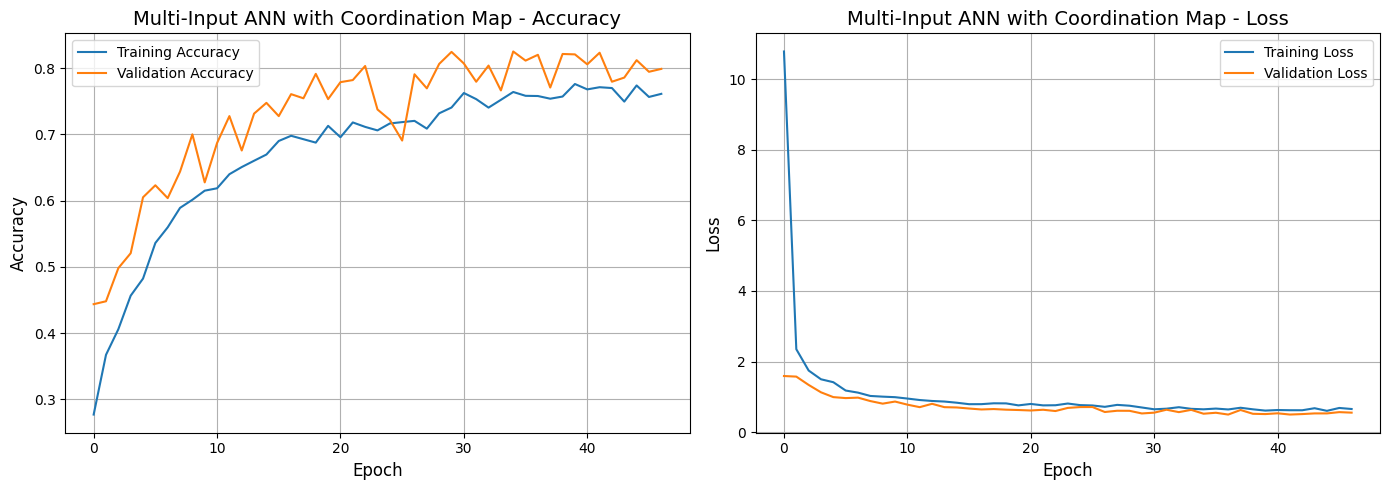

50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step


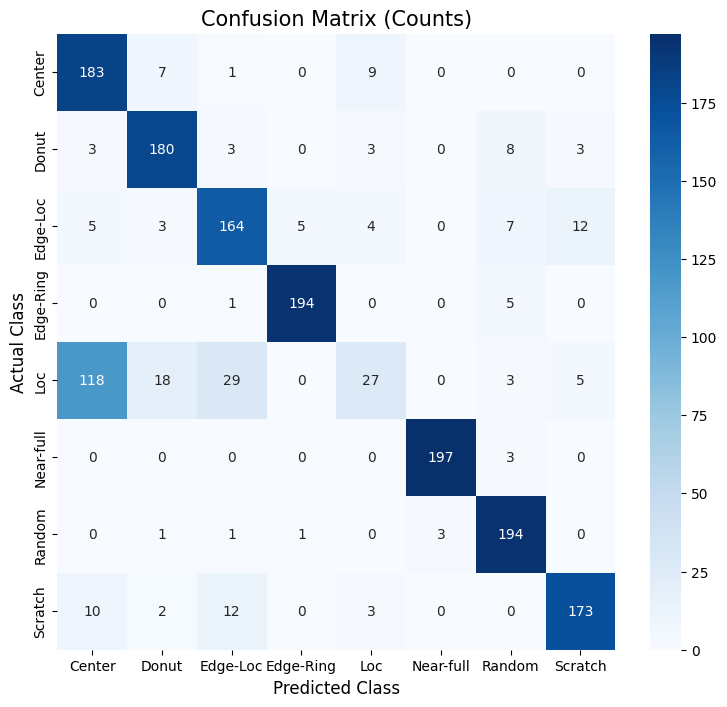

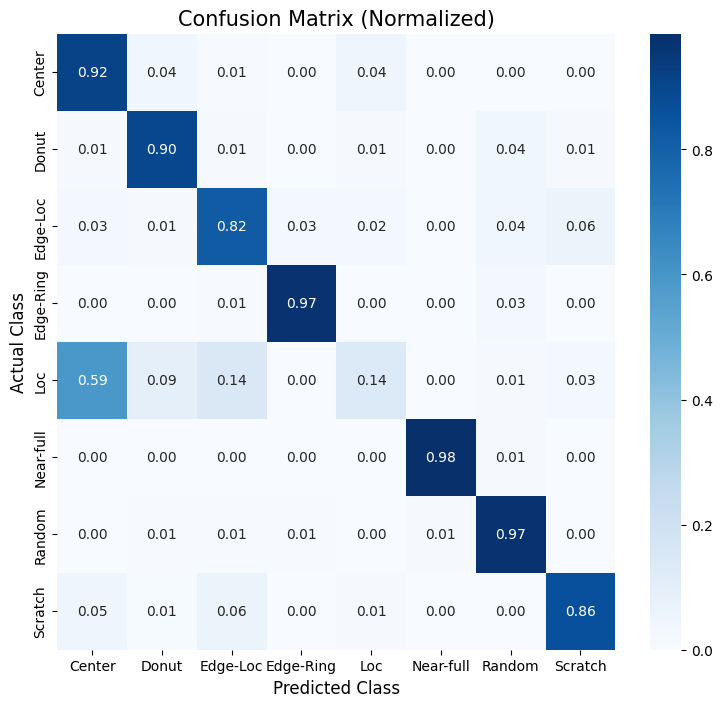

In [16]:
# 훈련 모델 성능 시각화
plot_training_history(history_coordmap_ann, "Multi-Input ANN with Coordination Map")

# 테스트 데이터로 예측 수행
y_pred_probs = model_coordmap_ann.predict([X_img_test, X_coords_test])

# 혼동 행렬 시각화
plot_confusion_matrix(y_test, y_pred_probs, encoder.classes_, normalize=False, title='Confusion Matrix (Counts)')

plot_confusion_matrix(y_test, y_pred_probs, encoder.classes_, normalize=True, title='Confusion Matrix (Normalized)')

# **성능 비교 결과**

In [17]:
import pandas as pd
import numpy as np
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# 평가할 모델들을 딕셔너리로 정의
models_to_evaluate = {
    "Multi-Input NN": model_coordmap_nn,
    "Multi-Input DNN": model_coordmap_dnn,
    "Multi-Input ANN": model_coordmap_ann,
    "Multi-Input CNN": model_coordmap_cnn,
}

results = []

y_test_classes = np.argmax(y_test, axis=1)

# 모델 별 성능 평가
for model_name, model in models_to_evaluate.items():

  # 예측 수행
  y_pred_probs = model.predict([X_img_test, X_coords_test], verbose=0)

  # 예측된 확률을 최종 클래스로 변환
  y_pred_classes = np.argmax(y_pred_probs, axis=1)

  # 평가 지표 계산
  accuracy = accuracy_score(y_test_classes, y_pred_classes)
  precision = precision_score(y_test_classes, y_pred_classes, average='weighted', zero_division=0)
  recall = recall_score(y_test_classes, y_pred_classes, average='weighted', zero_division=0)
  f1 = f1_score(y_test_classes, y_pred_classes, average='weighted', zero_division=0)

  # 결과 저장
  results.append({
      "Model": model_name,
      "Accuracy": accuracy,
      "Precision": precision,
      "Recall": recall,
      "F1-Score": f1
  })

# 최종 결과 출력
results_df = pd.DataFrame(results)
results_df_sorted = results_df.sort_values(by='F1-Score', ascending=False).reset_index(drop=True)

print("\n\n--- 최종 모델 성능 비교표 (F1-Score 기준 정렬) ---")
display(results_df_sorted)



--- 최종 모델 성능 비교표 (F1-Score 기준 정렬) ---


,Model,Accuracy,Precision,Recall,F1-Score
0,Multi-Input DNN,0.90125,0.908681,0.90125,0.901560
1,Multi-Input CNN,0.87625,0.880758,0.87625,0.876764
2,Multi-Input NN,0.86625,0.861441,0.86625,0.861562
3,Multi-Input ANN,0.82000,0.815518,0.82000,0.794737
